<a href="https://colab.research.google.com/github/ctclumak/posts/blob/master/Content_Analysis_with_NLTK%2C_LDA_AND_LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install pyLDAvis

# **IMPORT PACKAGES**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pprint import pprint
from string import punctuation 
from random import shuffle

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


# **IMPORT DATASET**

In [4]:
df = pd.read_csv("1429_1.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Calculate the Sentiment Polarity with TextBlob**
- The score is in between [-1,1], where 1 means positive sentiment and -1 means a negative sentiment.

In [9]:
from textblob import TextBlob
df['polarity'] = df["reviews.text"].astype(str).map(lambda text: TextBlob(text).sentiment.polarity)


In [10]:
df['polarity'].value_counts(sort=True, ascending=False)

 0.000000    2000
 0.500000    1641
 0.800000    1073
 1.000000     875
 0.400000     619
             ... 
-0.121429       1
 0.301894       1
 0.080556       1
 0.547083       1
 0.081944       1
Name: polarity, Length: 7595, dtype: int64

In [11]:
df.polarity.min()

-1.0

In [12]:
print('5 random reviews with the highest positive sentiment polarity: \n') 
cl = df.loc[df.polarity == 1, ["reviews.text"]].sample(5).values
for c in cl: 
   print(c[0])

print('\n5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df.loc[df.polarity == 0, ["reviews.text"]].sample(5).values
for c in cl:
    print(c[0])

print('\n5 reviews with the most negative polarity: \n')
cl = df.loc[df.polarity <= -0.9, ["reviews.text"]].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

This tablet works wondeful and it is perfect for children who are learning to read and do math.
My daughter loves her tablet and it's great for movies and games!
I like the color quality of the tablet and the size is perfect for at home or on the go.
this is the perfect table to download books from Amazon....
Wonderful kindle, i have been reading a lot of things that I now can reach

5 random reviews with the most neutral sentiment(zero) polarity: 

This does everything i need and want it to do. All extras in one place.
Come on, $39.99 for a tablet! Value, value, value.
This is a Christmas present so it hasn't been used yet
Purchased as a birthday gift for grandson and he LOVES it.
Fire TV streams shows and movies without buffering at all

5 reviews with the most negative polarity: 

We are a Kindle family! Use them all the time! Reading books, checking email, watching Netflix. Would be very sad without it!!!
Goodbye outr

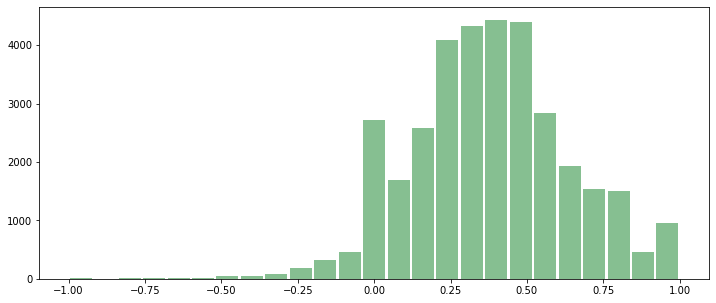

In [13]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot
plt.figure(figsize=(12,5))
df.polarity.hist(grid=False,bins=25,color='#86bf91', zorder=2, rwidth=0.9)
display()


# **DATA PRE-PROCESSING**
**REMOVE NOISE: Punctuation, white space, numbers, stop word and normalize**

In [14]:
def processor(text):
  punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
  text = text.astype(str).apply(lambda x: ' '.join(ch for ch in x.lower().split() if ch not in set(punctuation)))
  text = text.str.replace("[0-9]", " ")
  return text

#create a function to normalize the text
def lemmatization(texts):
  nlp=spacy.load("en", disable=['parser', 'ner']) ## This is to remove stop words
  output =[]
  for i in texts:
    s = [token.lemma_ for token in nlp(i)]
    output.append(' '.join(s))
  return output

df["clean_reviews"] = lemmatization(processor(df["reviews.text"]))

**Tokenization**

In [15]:
def ReturnTokens(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tokens = list(ReturnTokens(df["clean_reviews"]))

#Creating Bag of Words Corpus
gensim_dictionary = corpora.Dictionary(simple_preprocess(str(sentence), deacc=True) for sentence in df["clean_reviews"])
gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in tokens]

In [ ]:
#gensim_dictionary.token2id

**Word Frequency - Term Frequency**

In [ ]:
# Human readable format of corpus (term-frequency)
word_frequencies=[[(gensim_dictionary[id], freq) for id, freq in cp] for cp in gensim_corpus]
word_frequencies

**Unigrams**

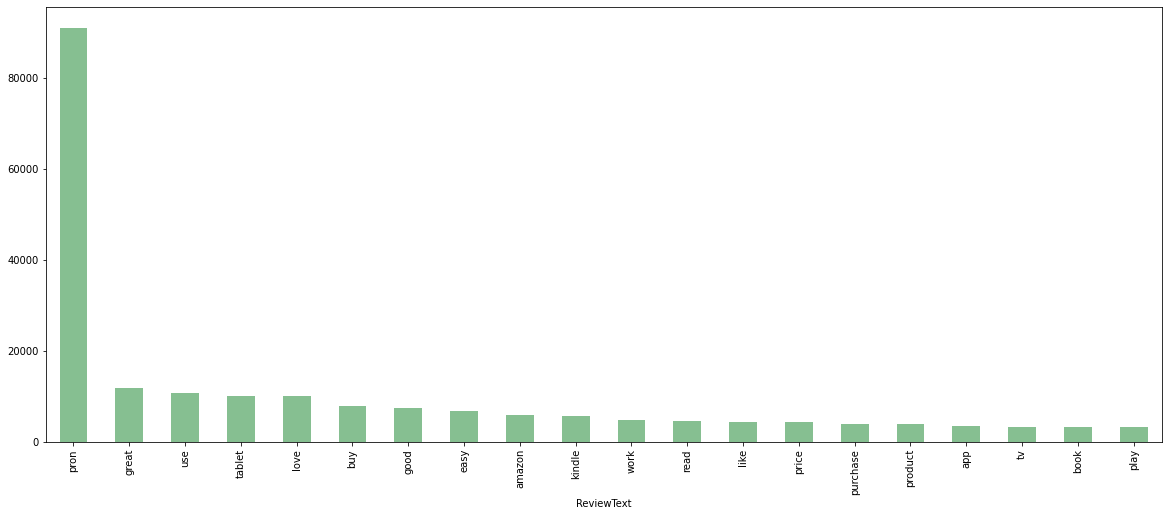

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

#Unigrams
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df["clean_reviews"], 20)
# for word, freq in common_words:
#      print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',grid=False,color='#86bf91', figsize=(20,8))
display()

**Bigrams**

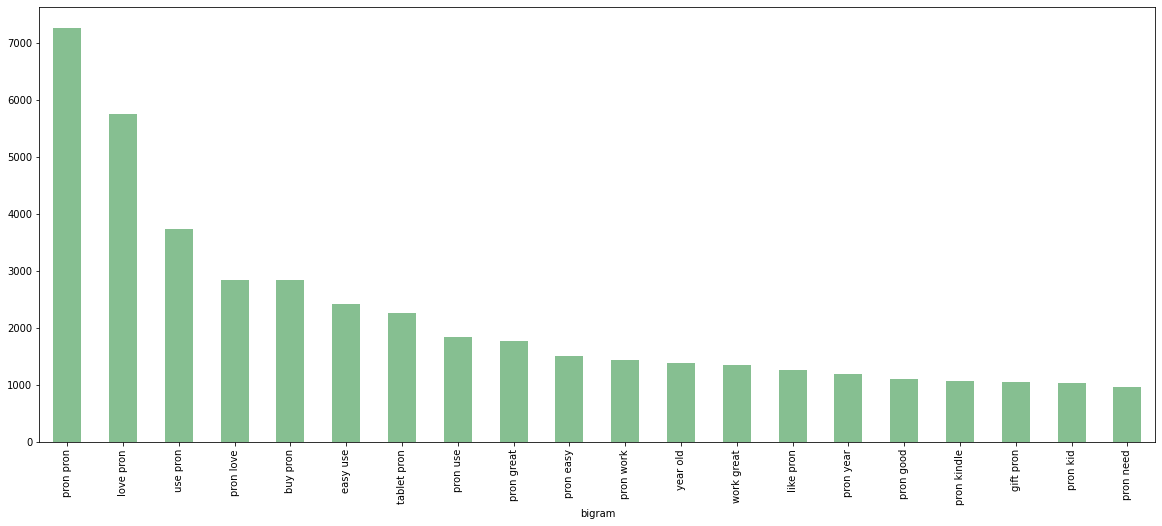

In [18]:
#Bigrams
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df["clean_reviews"], 20)
# for word, freq in common_words:
#      print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

df1.groupby('bigram').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',grid=False,color='#86bf91', figsize=(20,8))
display()


**Trigrams**

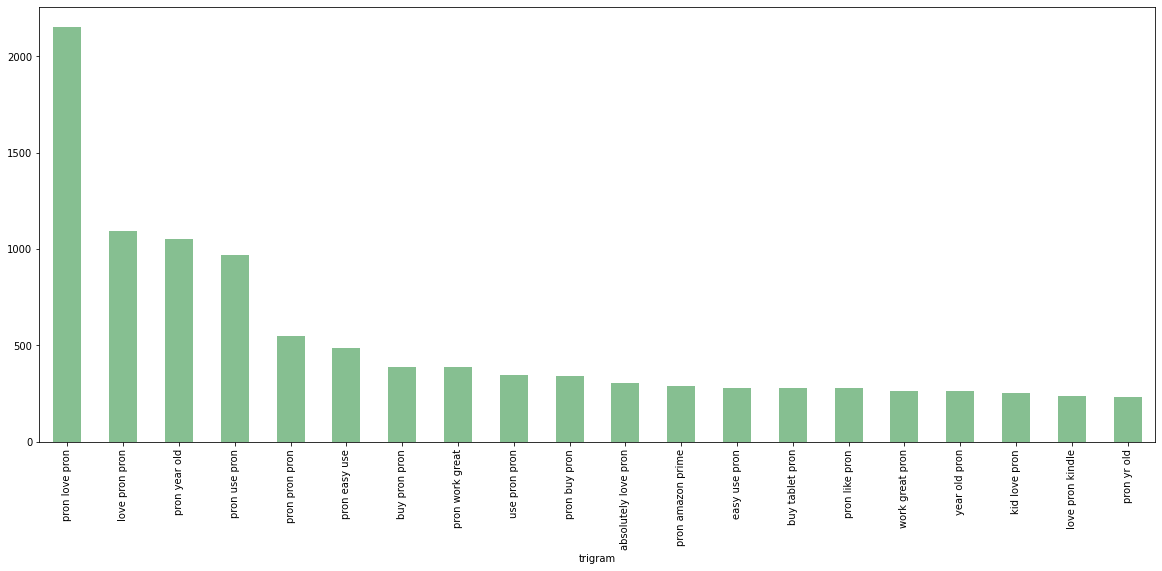

In [19]:
#Trigrams
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df["clean_reviews"], 20)
# for word, freq in common_words:
#      print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

df1.groupby('trigram').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',grid=False,color='#86bf91', figsize=(20,8))
display()

**Word Frequency with TD-IDF**
- The bag of words approach works fine for converting text to numbers and assigns a score to a word based on its occurrence in a particular document. 
  - Term frequency = (Frequency of the word in a document)/(Total words in the document)
- TF-IDF also take into account the fact that the word might also have a high frequency of occurrences in other documents.

  - IDF(word) = Log((Total number of documents)/(Number of documents containing the word))

In [20]:
from gensim import models
tfidf = models.TfidfModel(gensim_corpus, smartirs='ntc')

for sent in tfidf[gensim_corpus]:
    print([[gensim_dictionary[id], np.around(frequency, decimals=2)] for id, frequency in sent])

Streaming output truncated to the last 5000 lines.
[['and', 0.05], ['have', 0.04], ['not', 0.05], ['pron', 0.01], ['the', 0.02], ['this', 0.09], ['to', 0.04], ['with', 0.05], ['for', 0.05], ['great', 0.04], ['be', 0.02], ['in', 0.06], ['of', 0.1], ['card', 0.14], ['need', 0.18], ['sd', 0.16], ['would', 0.08], ['device', 0.35], ['anyone', 0.14], ['recommend', 0.09], ['problem', 0.13], ['option', 0.14], ['any', 0.23], ['highly', 0.13], ['processor', 0.18], ['no', 0.1], ['gb', 0.17], ['ram', 0.22], ['handle', 0.18], ['streaming', 0.14], ['mobile', 0.21], ['digital', 0.21], ['wireless', 0.18], ['mention', 0.21], ['receiver', 0.23], ['plug', 0.16], ['core', 0.23], ['quad', 0.23], ['usb', 0.19], ['ac', 0.25]]
[['and', 0.04], ['content', 0.15], ['have', 0.04], ['pron', 0.05], ['the', 0.08], ['to', 0.06], ['buy', 0.06], ['for', 0.05], ['great', 0.04], ['be', 0.08], ['all', 0.08], ['at', 0.09], ['fire', 0.08], ['in', 0.06], ['member', 0.15], ['of', 0.05], ['prime', 0.12], ['watch', 0.11], ['age

**Find similar word with FastText**

In [ ]:
# from gensim.models import FastText
# model_ted = FastText(tokens, size=100, window=5, min_count=5, workers=4,sg=1)
# model_ted.wv.most_similar("processor")

**Save the dictionary and corpus with Pickle**
- The saved dictionary can be used on new data

In [21]:
import pickle

pickle.dump(gensim_corpus, open('gensim_corpus_corpus.pkl', 'wb'))
gensim_dictionary.save('gensim_dictionary.gensim')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



**Get Top N Words**

# **Topic Modeling with LDA**

In [22]:
# Build LDA model
n_topics=10
lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus,
                                           id2word=gensim_dictionary,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**View the topics in LDA model**

In [ ]:
# Print print 5 keywords per topic
topics= lda_model.print_topics(num_words=5)
#doc_lda = lda_model[corpus]
for topic in topics:
    print(topic)

(0, '0.080*"go" + 0.073*"voice" + 0.044*"item" + 0.039*"setup" + 0.037*"wifi"')
(1, '0.253*"to" + 0.129*"tv" + 0.070*"use" + 0.052*"and" + 0.048*"easy"')
(2, '0.188*"up" + 0.099*"set" + 0.051*"faster" + 0.044*"into" + 0.025*"anyone"')
(3, '0.087*"lot" + 0.086*"alexa" + 0.049*"control" + 0.042*"medium" + 0.032*"system"')
(4, '0.155*"product" + 0.092*"recommend" + 0.042*"service" + 0.036*"pay" + 0.031*"highly"')
(5, '0.143*"not" + 0.106*"do" + 0.063*"as" + 0.034*"need" + 0.031*"want"')
(6, '0.125*"the" + 0.104*"be" + 0.051*"have" + 0.032*"of" + 0.027*"with"')
(7, '0.393*"pron" + 0.112*"and" + 0.084*"this" + 0.081*"for" + 0.035*"love"')
(8, '0.046*"cover" + 0.044*"find" + 0.042*"kodi" + 0.037*"cut" + 0.033*"try"')
(9, '0.176*"fire" + 0.070*"box" + 0.068*"cable" + 0.066*"stick" + 0.037*"kindle"')


**Compute Model Perplexity and Coherence Score**

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(gensim_corpus))  # a measure of how good the model is. lower the better.
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_score_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=gensim_dictionary, coherence='c_v')
coherence_lda = coherence_score_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.9873635028160495

Coherence Score:  0.3553957514361616


**Visualizing the topics-keywords**

In [24]:
#The following code is to used the save dictionary and corpus
# gensim_dictionary = gensim.corpora.Dictionary.load('gensim_dictionary.gensim')
# gensim_corpus = pickle.load(open('gensim_corpus_corpus.pkl', 'rb'))
# lda_model = gensim.models.ldamodel.LdaModel.load('gensim_model.gensim')

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, gensim_corpus, gensim_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.272751  0.046598       1        1  38.971081
7      0.271283 -0.055382       2        1  21.142397
1      0.222884 -0.109089       3        1  13.313720
5     -0.044447  0.411065       4        1   7.612641
9     -0.061012  0.074551       5        1   5.397104
0     -0.136584 -0.085484       6        1   3.161390
8     -0.128027 -0.080273       7        1   2.883786
4     -0.110004 -0.043976       8        1   2.839372
3     -0.146516 -0.078281       9        1   2.415349
2     -0.140327 -0.079730      10        1   2.263156, topic_info=             Term          Freq         Total Category  logprob  loglift
14           pron  83535.000000  83535.000000  Default  30.0000  30.0000
19             to  33819.000000  33819.000000  Default  29.0000  29.0000
17            the  49089.000000  49089.000000  Default  28.0000  28.0000
33             be  40787.000000  40787.000000  Default  27.0000  27.0000
474            tv  17313.000000  17313.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1037  integration    140.093033    140.916290  Topic10  -5.0903   3.7826
965       monthly    138.589386    139.412582  Topic10  -5.1011   3.7825
1563       result    133.955185    134.778580  Topic10  -5.1351   3.7823
2623        guide    127.974373    128.797607  Topic10  -5.1808   3.7820
1329      digital    118.660141    119.483406  Topic10  -5.2563   3.7815

[349 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
45        3  0.999187        able
305       4  0.999386       about
843       2  0.996225  absolutely
46        3  0.998841      access
357       4  0.998879     account
...     ...       ...         ...
219       1  0.999862        work
166       1  0.999819       would
972       6  0.995270       wrong
167       2  0.999576        year
808       5  0.996945         yet

[335 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 2, 6, 10, 1, 9, 5, 4, 3])

# **Topic Modeling with LSA**

In [38]:
detokenized_doc = []
for i in range(len(df["reviews.text"])):
    t = ' '.join(tokens[i])
    detokenized_doc.append(t)

df['clean_doc'] = detokenized_doc

**Document-Term Matrix**

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)

document_term_matrix = vectorizer.fit_transform(df['clean_doc'])

**Topic Modeling**

In [41]:
from sklearn.decomposition import TruncatedSVD
n_topics=10
# SVD represent documents and terms in vectors 
lsa_model = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=100, random_state=122)
lsa_topic_matrix=lsa_model.fit_transform(document_term_matrix)

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

In [43]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

def get_top_n_words(n, keys, document_term_matrix, vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
    
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  pron love tablet
Topic 2:  great tablet price
Topic 3:  easy use set
Topic 4:  tablet perfect easy
Topic 5:  good kindle pron
Topic 6:  kindle read book
Topic 7:  good product buy
Topic 8:  tv stick amazon
Topic 9:  love amazon kid
Topic 10:  product recommend highly


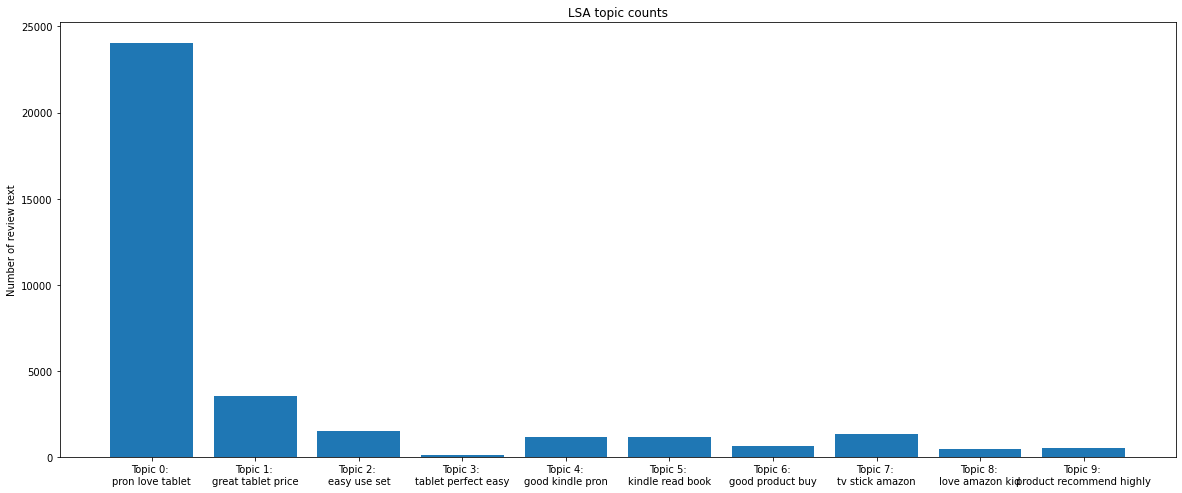

In [44]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

In [45]:
from sklearn.manifold import TSNE
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 34660 samples in 0.058s...
[t-SNE] Computed neighbors for 34660 samples in 14.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34660
[t-SNE] Computed conditional probabilities for sample 2000 / 34660
[t-SNE] Computed conditional probabilities for sample 3000 / 34660
[t-SNE] Computed conditional probabilities for sample 4000 / 34660
[t-SNE] Computed conditional probabilities for sample 5000 / 34660
[t-SNE] Computed conditional probabilities for sample 6000 / 34660
[t-SNE] Computed conditional probabilities for sample 7000 / 34660
[t-SNE] Computed conditional probabilities for sample 8000 / 34660
[t-SNE] Computed conditional probabilities for sample 9000 / 34660
[t-SNE] Computed conditional probabilities for sample 10000 / 34660
[t-SNE] Computed conditional probabilities for sample 11000 / 34660
[t-SNE] Computed conditional probabilities for sample 12000 / 34660
[t-SNE] Computed conditional probabilities for s

****Topics Visualization with TSNE****

In [51]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
#COLOURMAP
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

#TSNE
plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])
p = figure()
show(plot)

**Topics Visualization with UMAP**

In [56]:
import umap
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(lsa_topic_matrix)
plot = figure(title="UMAP Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(embedding[:,0], embedding[:,1], color=colormap[lsa_keys])
show(plot)
